In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!unzip "/content/drive/MyDrive/Northeastern Projects/Capstone Data/Phase 2/jigsaw-toxic-comment-classification-challenge.zip"

Archive:  /content/drive/MyDrive/Northeastern Projects/Capstone Data/Phase 2/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
!unzip "/content/train.csv.zip"

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [ ]:
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import nltk
import nltk
import numpy as np
import pandas as pd
import re
import re
import seaborn as sns
import spacy
import string
import string as string
import sys
import warnings

nltk.download('stopwords')
pd.set_option('display.max_columns', 500)
stopword = set(STOPWORDS)
sys.setrecursionlimit(5000)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Exploratory Data Analysis

## 1. Checking Null Values.

In [ ]:
col_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Taking the sum of all the toxic classes to identify multi class and is the comment toxic or not
df_train['Sum'] = df_train[col_list].sum(axis = 1)

In [ ]:
# Checking the count of missing values in the data
print("Check for missing values in the dataset")
df_train.isnull().sum()

Check for missing values in the dataset


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Sum              0
dtype: int64

## 2. Distribution of Comments for each toxicity class.

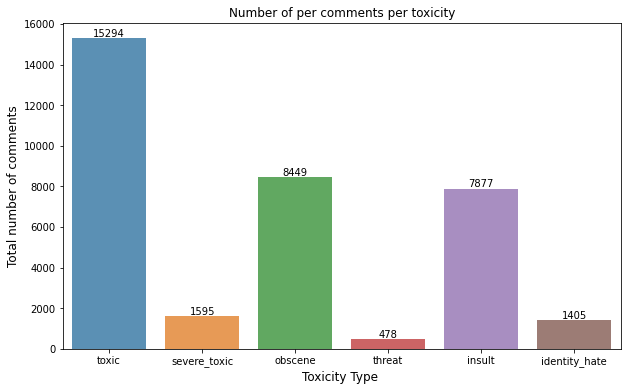

In [ ]:
# Subsetting the data to just focus on toxic classes
x = pd.DataFrame(df_train.iloc[:,2:8].sum()).reset_index()

# Plotting the nuber of comments for each toxic class
plt.figure(figsize = (10, 6))
ax = sns.barplot(x=x['index'], y = x[0], alpha = 0.8)
plt.title("Number of per comments per toxicity")
plt.ylabel('Total number of comments', fontsize = 12)
plt.xlabel('Toxicity Type ', fontsize = 12)

rects = ax.patches
labels = x[0]

# Adjusting the Height and Width of the Labels for clear plot
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = 'center', va = 'bottom')

plt.show()

## 3. Distribution of comments with multiple toxicity class.

In [ ]:
# Counting the number of comments for analyzing multiple classes
x = pd.DataFrame(df_train['Sum'].value_counts()).reset_index()
x.columns = ['Toxicities', 'Count']

# Calculating the percentage for each class
x['Percentage'] = round(x['Count'] / len(df_train) * 100, 2)

# Displaying the dataframe
display(x)

,Toxicities,Count,Percentage
0,0,143346,89.83
1,1,6360,3.99
2,3,4209,2.64
3,2,3480,2.18
4,4,1760,1.10
5,5,385,0.24
6,6,31,0.02


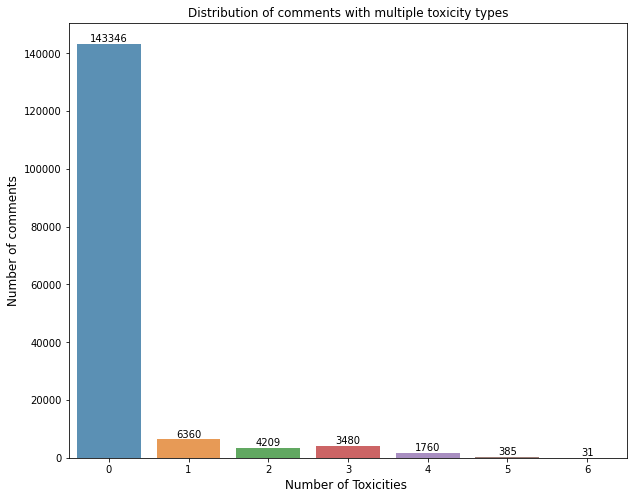

In [ ]:
# Plotting the nuber of comments for each multi class toxicity
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = x['Toxicities'], y = x['Count'], alpha = 0.8)
plt.title("Distribution of comments with multiple toxicity types")
plt.ylabel('Number of comments', fontsize = 12)
plt.xlabel('Number of Toxicities ', fontsize = 12)

rects = ax.patches
labels = x['Count']

# Adjusting the Height and Width of the Labels for clear plot
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha = 'center', va = 'bottom')

plt.show()

## 4. Analyzing Overlaps between different classes

In [ ]:
def plot_venn_diagram(df):
    fig, axes = plt.subplots(2,2,figsize=(20,20))

    # Retreving the index for each target class
    toxic = set(df[df['toxic']==1].index)
    severe_toxic = set(df[df['severe_toxic']==1].index)
    obscene = set(df[df['obscene']==1].index)
    threat = set(df[df['threat']==1].index)
    insult = set(df[df['insult']==1].index)
    identity_hate = set(df[df['identity_hate']==1].index)

    # Plotting venn diagram for combination of 3 target classes
    v1 = venn3([toxic, severe_toxic, obscene],
          set_labels=('Toxic','Severe toxic','Obscene'), 
          set_colors=('#a5e6ff', '#3c8492','#9D8189'), ax=axes[0][0])
    for text in v1.set_labels:
        text.set_fontsize(22)

    v2 = venn3([threat, insult, identity_hate],
          set_labels=('Threat','Insult','Identity hate'), 
          set_colors=('#e196ce', '#F29CB7','#3c81a9'), ax=axes[0][1])
    for text in v2.set_labels:
        text.set_fontsize(22)
    
    v3 = venn3([toxic, insult, obscene],
          set_labels=('Toxic','Insult','Obscene'), 
          set_colors=('#a5e6ff', '#F29CB7','#9D8189'), ax=axes[1][0])
    for text in v3.set_labels:
        text.set_fontsize(22)
    
    v4 = venn3([threat, identity_hate, obscene],
          set_labels=('Threat','Identity hate','Obscene'), 
          set_colors=('#e196ce', '#3c81a9','#9D8189'), ax=axes[1][1])
    for text in v4.set_labels:
        text.set_fontsize(22)
    
    plt.show()

    return

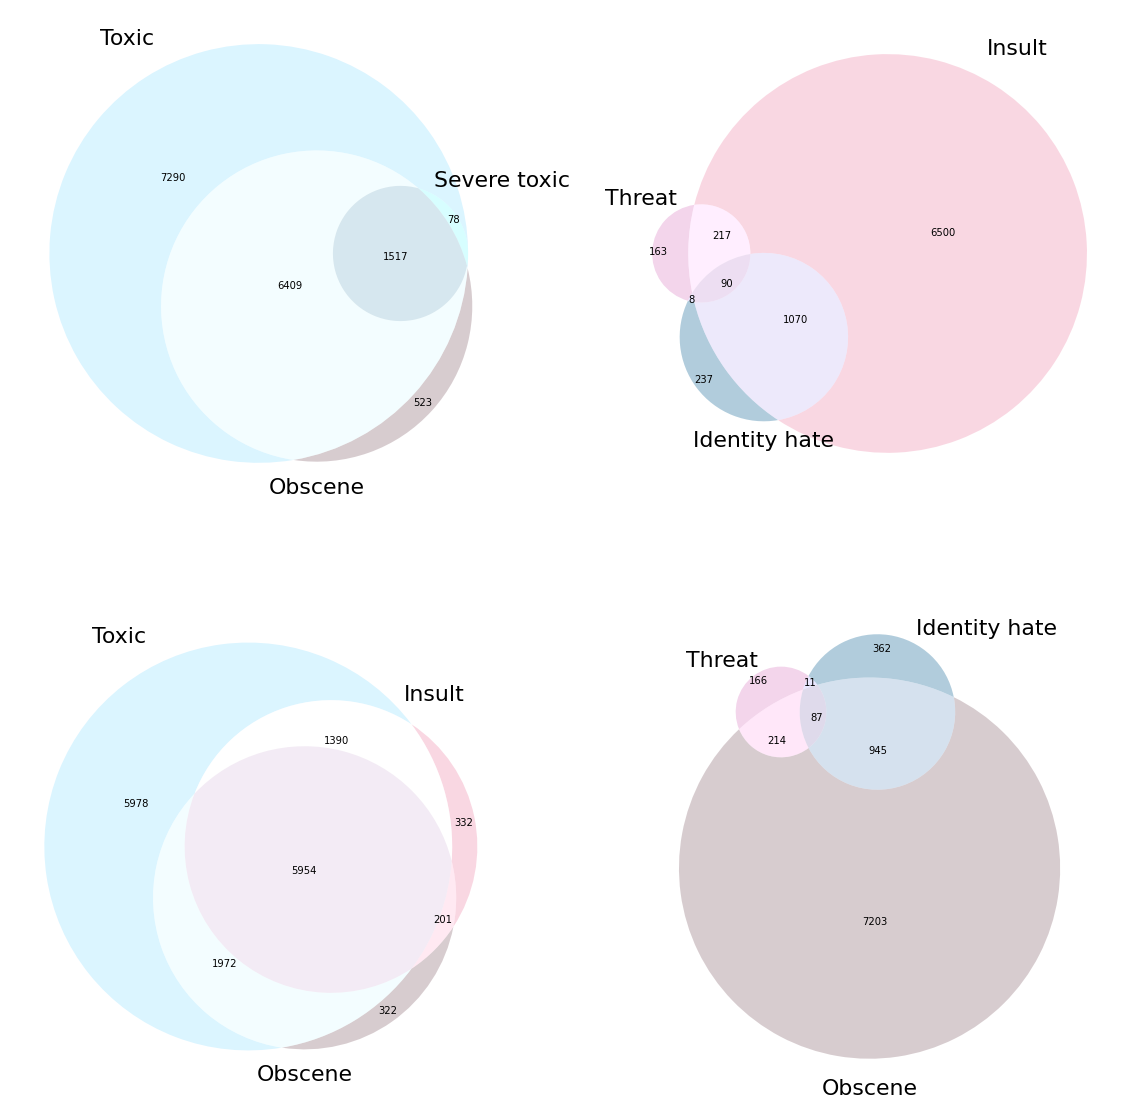

In [ ]:
plot_venn_diagram(df_train)

## 4. Comment Length Statistics

In [ ]:
# Calculating the mean, max and min length of the comment across the dataset
lens = df_train.comment_text.str.len()
print("Before cleaning the text ... ")
print("Average lenght of comments :", round(lens.mean(), 2))
print("Maximum lenght of comment :", lens.max())
print("Maximum lenght of comment :", lens.min())

Before cleaning the text ... 
Average lenght of comments : 394.07
Maximum lenght of comment : 5000
Maximum lenght of comment : 6


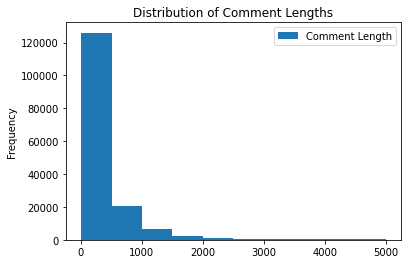

In [ ]:
# Plotting the Distribution of the Comment Length
lens_df = pd.DataFrame(list(lens), columns = ['Comment Length'])
ax = lens_df.plot.hist(xlabel = 'Comment Length')
ax.set_title('Distribution of Comment Lengths')
plt.show()

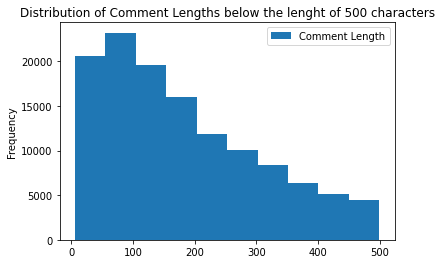

In [ ]:
# Plotting the Distribution of the Comments having Length less than 500
lens_df = pd.DataFrame(list(lens[lens < 500]), columns = ['Comment Length'])
ax = lens_df.plot.hist(xlabel = 'Comment Length')
ax.set_title('Distribution of Comment Lengths below the lenght of 500 characters')
plt.show()

In [ ]:
def length_stats_plot(df):
    target_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 
                      'insult', 'identity_hate', 'clean']

    median_len = []
    mean_len = []
    min_len = []
    max_len = []
    avg_unique_words = []

    df['word_count'] = df["comment_text"].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df["comment_text"].apply(lambda x: len(set(str(x).split())))
    
    # Adding Target Variable Clean 
    df['clean'] = 0
    df.loc[df['Sum'] == 0, 'clean'] = 1
    
    for i in target_classes:
        mean_len.append(df[df[i]==1]['word_count'].mean())  
        min_len.append(df[df[i]==1]['word_count'].min())  
        max_len.append(df[df[i]==1]['word_count'].max())  
        median_len.append(df[df[i]==1]['word_count'].median())  
        avg_unique_words.append(df[df[i]==1]['unique_word_count'].mean())
        
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    sns.barplot(ax=axes[0,0], x = target_classes, y = median_len, alpha = 0.8)
    axes[0,0].set_title('Median Comment Length')

    sns.barplot(ax=axes[1,0], x = target_classes, y = mean_len, alpha = 0.8)
    axes[0,1].set_title('Average Comment Length')

    sns.barplot(ax=axes[0,1], x = target_classes, y = min_len, alpha = 0.8)
    axes[1,0].set_title('Minimum Comment Length')
    
    sns.barplot(ax=axes[1,1], x = target_classes, y = avg_unique_words, alpha = 0.8)
    axes[1,1].set_title('Average Unique Words')

    fig.suptitle('Comment length statistics across categories')
    plt.show()
    
    return 

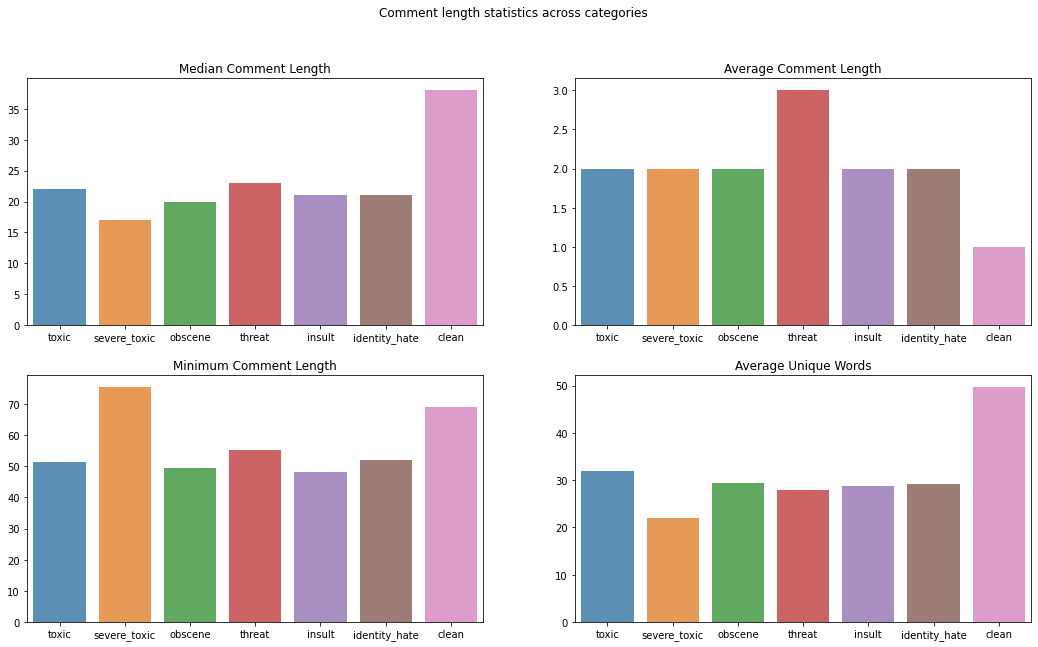

In [ ]:
length_stats_plot(df_train)

## 5. Correlation of different toxicity types

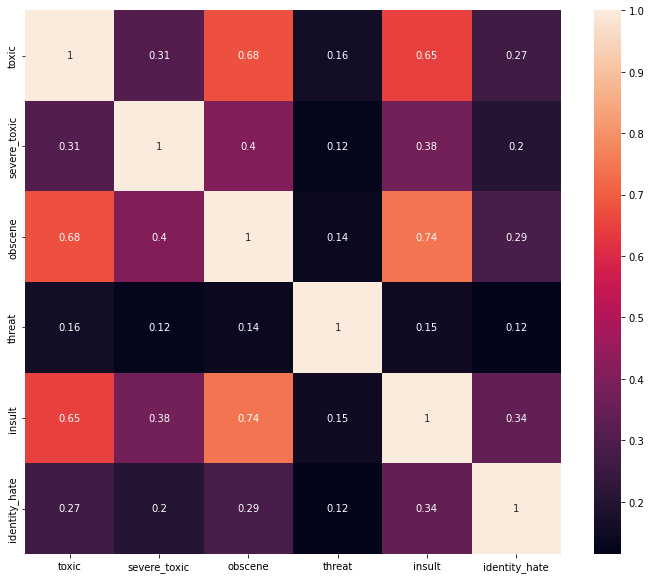

In [ ]:
# Finding the correlation amongst each toxic class
corr = df_train[col_list].corr()

# Plotting the heatmap to visualize the correaltions
plt.figure(figsize = (12, 10))
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, annot = True)
plt.show()

## 6. Overlapping of comment across multiple toxicity

In [ ]:
# Counting the number of comments that are overlapping between different toxic levels
temp_df = df_train[col_list]
main_col = "toxic"
corr_mats = []

for other_col in temp_df.columns[1:]:
  confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
  corr_mats.append(confusion_matrix)

out = pd.concat(corr_mats, axis = 1,keys = temp_df.columns[1:])

display(out)

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302

## 7. Word Cloud For Non Toxic Comments

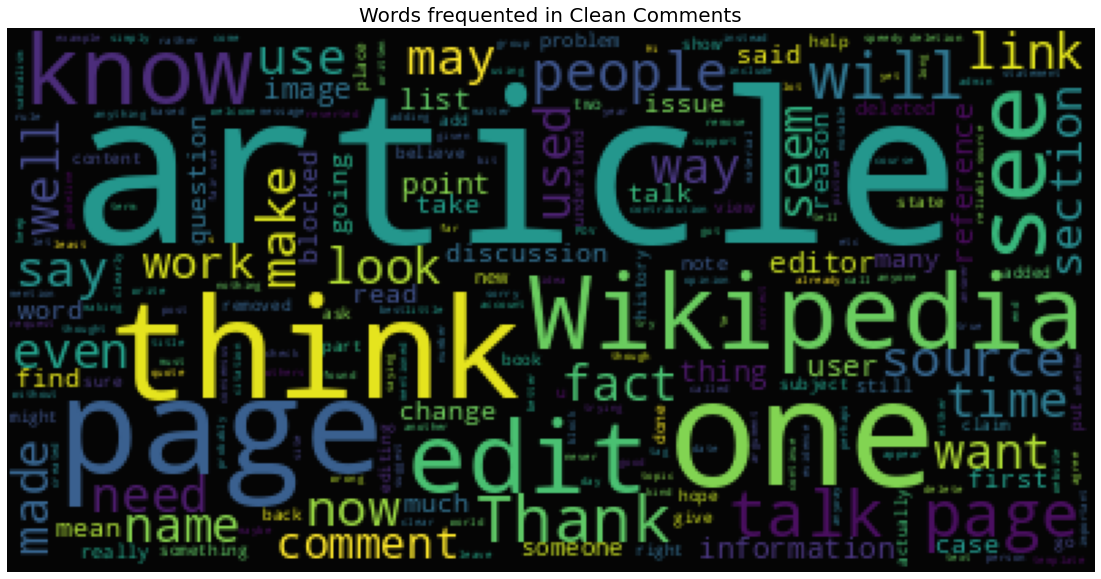

In [ ]:
# Subsetting the data to only those comments who are not toxic
subset = df_train[df_train.Sum == 0]
text = subset.comment_text.values

# Visualizing the Word Cloud of top 200 words that are present in the non toxic comments
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(text))
plt.figure(figsize = (20, 10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'viridis' , random_state = 17), alpha = 0.98)
plt.show()

## 8. Word Cloud For All Toxic Comments Types

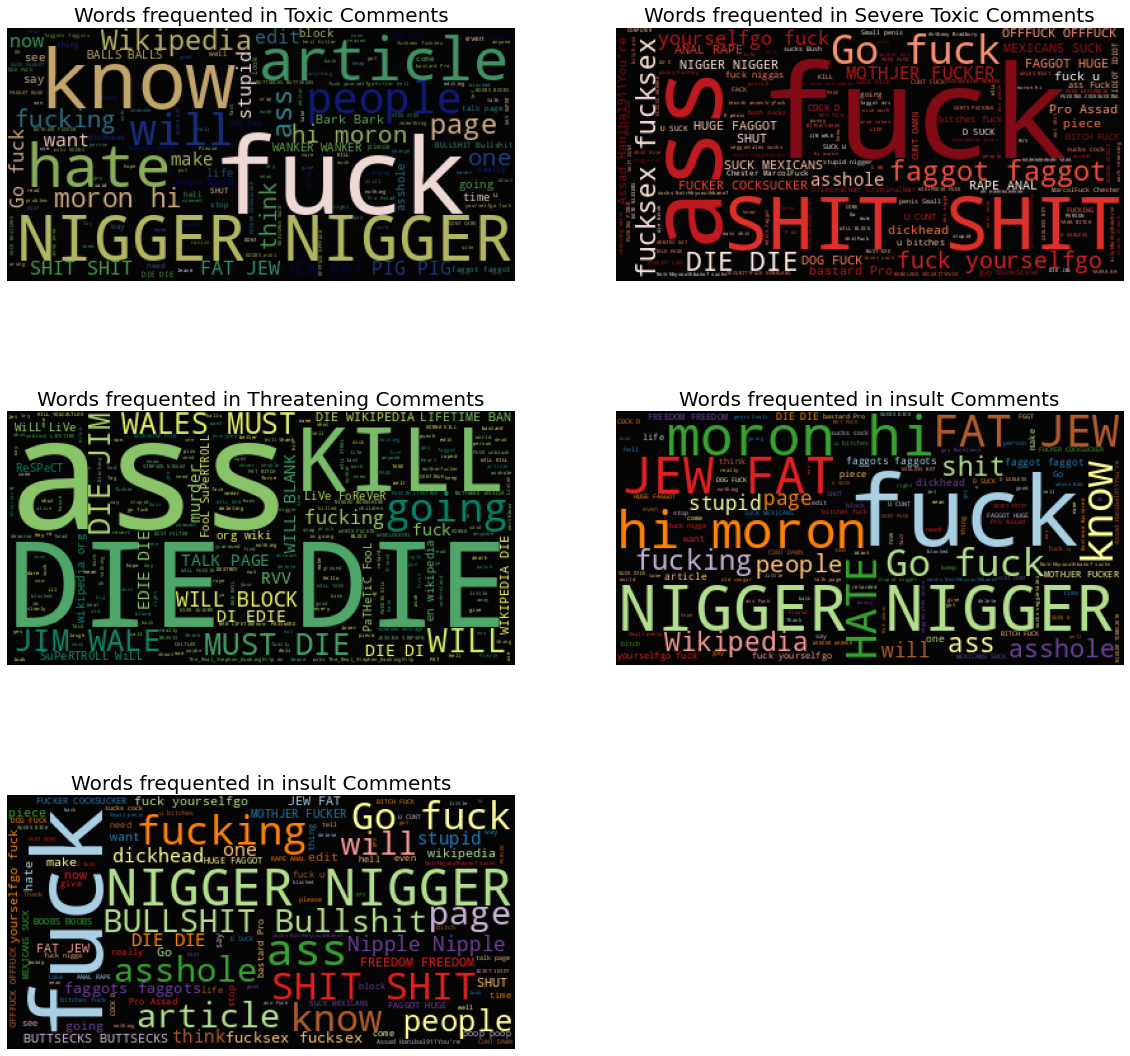

In [ ]:
# Subsetting the data to only toxic class comment and visualizing the wordcloud
subset = df_train[df_train.toxic == 1]
text = subset.comment_text.values
wc = WordCloud(background_color = "black",max_words = 4000, stopwords = stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'gist_earth' , random_state = 244), alpha = 0.98)

# Subsetting the data to only Severely toxic comments comment and visualizing the wordcloud 
plt.subplot(322)
subset = df_train[df_train.severe_toxic == 1]
text = subset.comment_text.values
wc = WordCloud(background_color = "black",max_words = 2000, stopwords = stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'Reds' , random_state = 244), alpha = 0.98)

# Subsetting the data to only Severely Threat comment and visualizing the wordcloud  
plt.subplot(323)
subset = df_train[df_train.threat == 1]
text = subset.comment_text.values
wc = WordCloud(background_color = "black",max_words = 2000,stopwords = stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state = 2534), alpha = 0.98)

# Subsetting the data to only Insulting comments and visualizing the wordcloud  
plt.subplot(324)
subset = df_train[df_train.insult == 1]
text = subset.comment_text.values
wc = WordCloud(background_color="black",max_words = 2000,stopwords = stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'Paired_r' , random_state = 244), alpha = 0.98)

# Subsetting the data to only Obscene comments and visualizing the wordcloud  
plt.subplot(325)
subset = df_train[df_train.obscene == 1]
text = subset.comment_text.values
wc = WordCloud(background_color = "black",max_words = 2000,stopwords = stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'Paired_r' , random_state = 244), alpha = 0.98)

plt.show()

## 9. Analyzing the Relationship between Toxicity and Number of Sentences and Words.

In [ ]:
temp = df_train.copy()

#Sentense count in each comment i.e we use \n to count the sentences
temp['sentence_count'] = temp["comment_text"].apply(lambda x: len(re.findall("\n",str(x))) + 1)

# Number of words in each comment
temp['word_count'] = temp["comment_text"].apply(lambda x: len(str(x).split()))

temp['is_toxic'] = np.nan

temp.loc[temp['Sum'] == 0, 'is_toxic'] = False

temp.loc[temp['Sum'] > 0, 'is_toxic'] = True

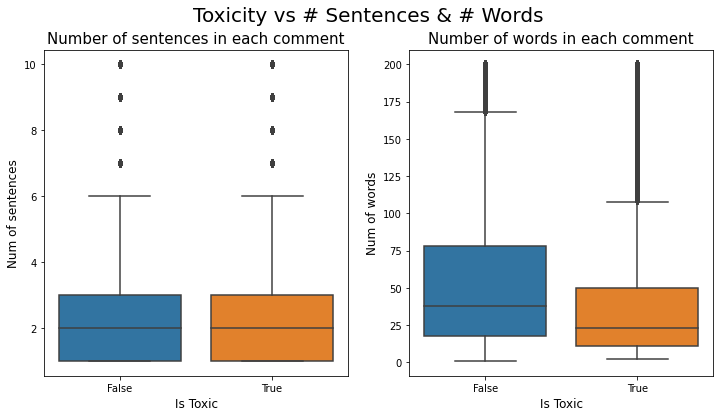

In [ ]:
# Analyzing whether the number of sentences and number of words affect the toxic classification
temp['sentence_count'].loc[temp['sentence_count'] > 10] = 10 
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.suptitle("Toxicity vs # Sentences & # Words", fontsize = 20)
sns.boxplot(y = 'sentence_count', x = 'is_toxic', data = temp)
plt.xlabel('Is Toxic', fontsize = 12)
plt.ylabel('Num of sentences', fontsize = 12)
plt.title("Number of sentences in each comment", fontsize = 15)

temp['word_count'].loc[temp['word_count'] > 200] = 200
plt.subplot(122)
sns.boxplot(y = 'word_count',x = 'is_toxic', data = temp)
plt.xlabel('Is Toxic', fontsize = 12)
plt.ylabel('Num of words', fontsize = 12)
plt.title("Number of words in each comment", fontsize = 15)

plt.show()

From the above plot we can see that long sentences or more words do not seem to have a significant relationship with toxicity.

# Feature Engineering

In [ ]:
#Sentense count in each comment i.e we use \n to count the sentences
df_train['sentence_count'] = df_train["comment_text"].apply(lambda x: len(re.findall("\n",str(x))) + 1)

# Number of words in each comment
df_train['word_count'] = df_train["comment_text"].apply(lambda x: len(str(x).split()))

# Unique word count
df_train['unique_word_count'] = df_train["comment_text"].apply(lambda x: len(set(str(x).split())))

# Comment length 
df_train['length'] = df_train["comment_text"].apply(lambda x: len(str(x)))

# punctuation count
df_train["punctuation_count"] = df_train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# upper case words count
df_train["upper_case_count"] = df_train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# stopword count
df_train["stopword_count"] = df_train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# tag count
df_train['#_count'] = df_train["comment_text"].apply(lambda x: len(re.findall("#",str(x))) + 1)

# Word count percent in each comment:
df_train['unique_word_count_percent'] = (df_train['unique_word_count'] /df_train['word_count']) * 100

# Punctuation percent in each comment:
df_train['Punctuation_percent'] = (df_train['punctuation_count'] / df_train['length']) * 100

In [ ]:
# count of IP addresses
df_train['ip_addresses'] = df_train["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
df_train['ip_count'] = df_train["ip_addresses"].apply(lambda x: len(x))
df_train = df_train.drop('ip_addresses', axis=1)

#Count of Links
df_train['link'] = df_train["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
df_train['link_count'] = df_train["link"].apply(lambda x: len(x))
df_train = df_train.drop('link', axis = 1)

#Count article ids
df_train['article_id'] = df_train["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df_train['article_id_count'] = df_train.article_id.apply(lambda x: len(x))
df_train = df_train.drop('article_id', axis=1)

#Count username
df_train['username'] = df_train["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
df_train['username_count'] = df_train["username"].apply(lambda x: len(x))

# Adding Target Variable Clean 
df_train['clean'] = 0
df_train.loc[df_train['Sum'] == 0, 'clean'] = 1

## Looking Closely at the Unique word count 

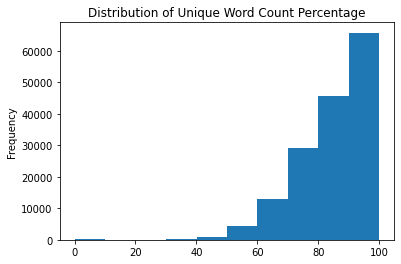

In [ ]:
ax = df_train['unique_word_count_percent'].plot.hist(xlabel = 'Unique Word Count Percentage')
ax.set_title('Distribution of Unique Word Count Percentage')
plt.show()

Number of comments with less than 40% unique word count :  580


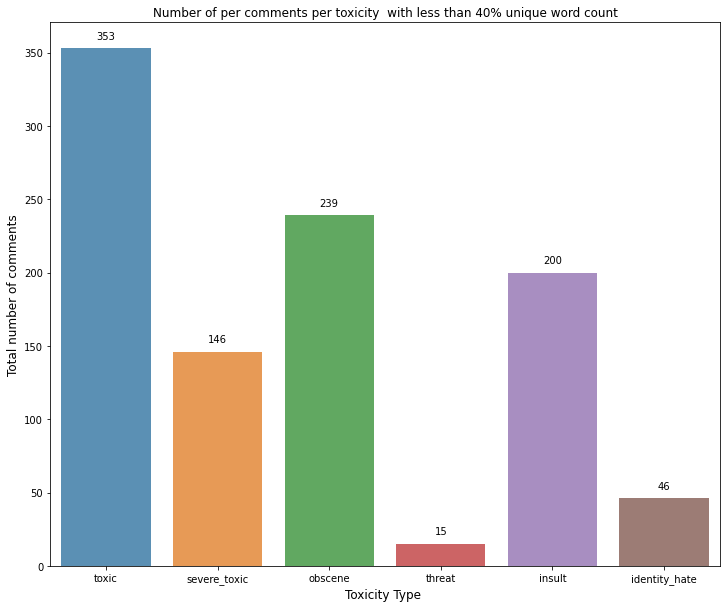

In [ ]:
df = df_train[df_train['unique_word_count_percent'] < 40]
print("Number of comments with less than 40% unique word count : ", len(df))
x = pd.DataFrame(df.iloc[:,2:8].sum()).reset_index()

plt.figure(figsize = (12, 10))
ax = sns.barplot(x = x['index'], y = x[0], alpha = 0.8)
plt.title("Number of per comments per toxicity  with less than 40% unique word count")
plt.ylabel('Total number of comments', fontsize = 12)
plt.xlabel('Toxicity Type ', fontsize = 12)

rects = ax.patches
labels = x[0]

for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha = 'center', va = 'bottom')

plt.show()

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def nlp_super_clean(text, stem = "None"):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(word[:10] if len(word) > 10 else word for word in text_stemmed)

    return final_string

In [ ]:
df_train['clean_comment'] = df_train['comment_text'].apply(lambda x: nlp_super_clean(x, stem = 'Stem'))

## N-Gram Analysis

In [ ]:
df_train['min_clean_text'] = df_train['comment_text'].apply(lambda x: nlp_super_clean(x, stem = None))

In [ ]:
def gram_analysis(data,gram):
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in data.lower().split(" ") if t!="" if t not in stop_words]
    ngrams = zip(*[tokens[i:] for i in range(gram)])
    tokens = [" ".join(z) for z in ngrams]

    return tokens

def gram_freq(df, gram, categ_col, text_col):
    category_text = " ".join(df[df[categ_col]==1][text_col].values)
    toks = gram_analysis(category_text, gram)
    tok_freq = pd.DataFrame(data=[toks, np.ones(len(toks))]).T.groupby(0).sum().reset_index()
    tok_freq.columns = ['token','frequency']
    tok_freq = tok_freq.sort_values(by='frequency',ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.title("{} most common tokens".format(categ_col))
    sns.barplot(x='token', y='frequency', data=tok_freq.iloc[:30])
    plt.xticks(rotation=90)
    plt.show()
    
    return

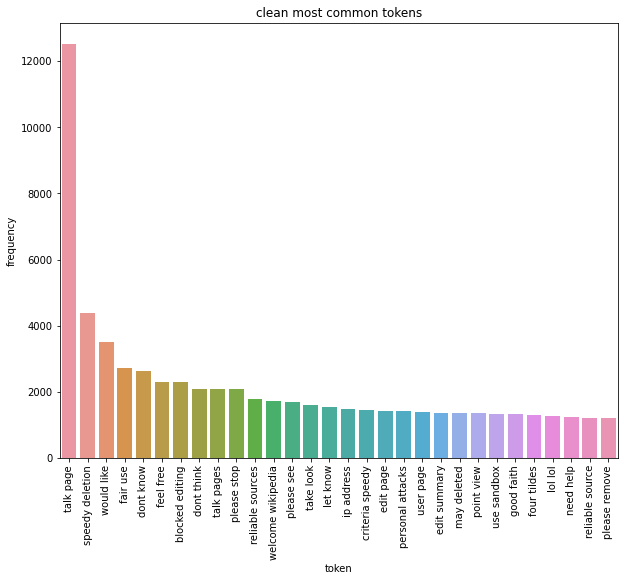

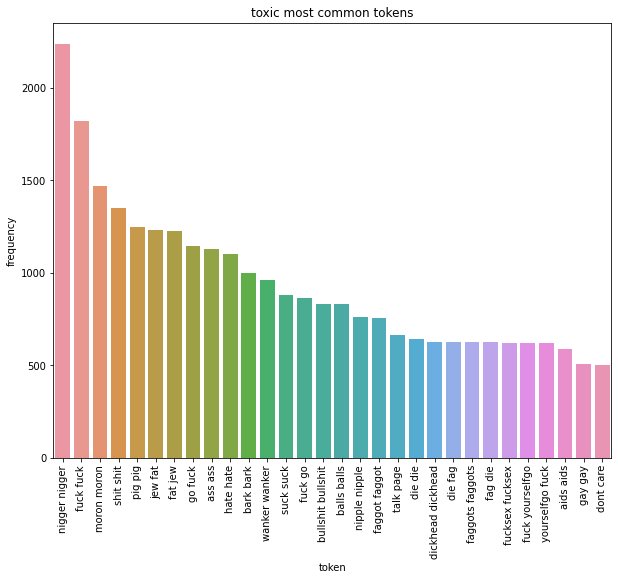

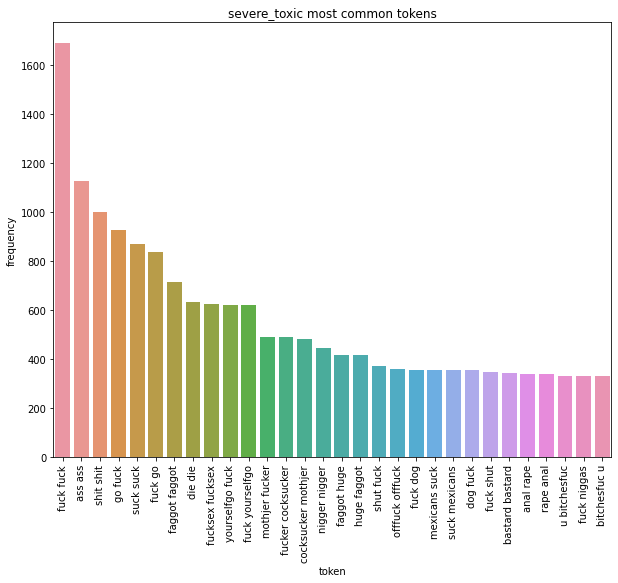

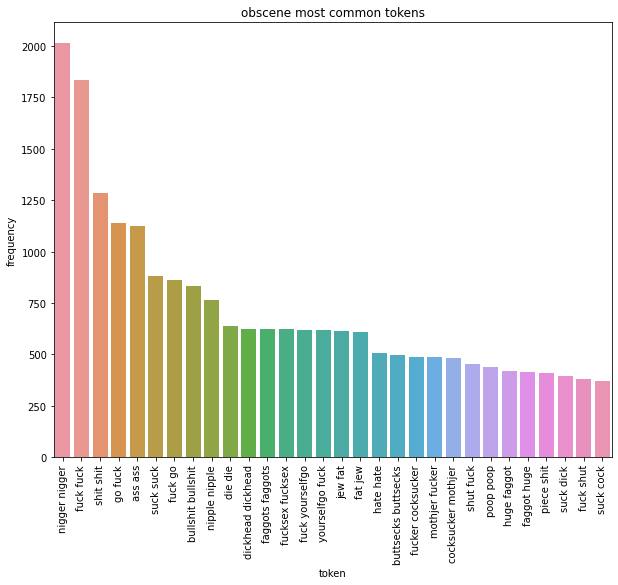

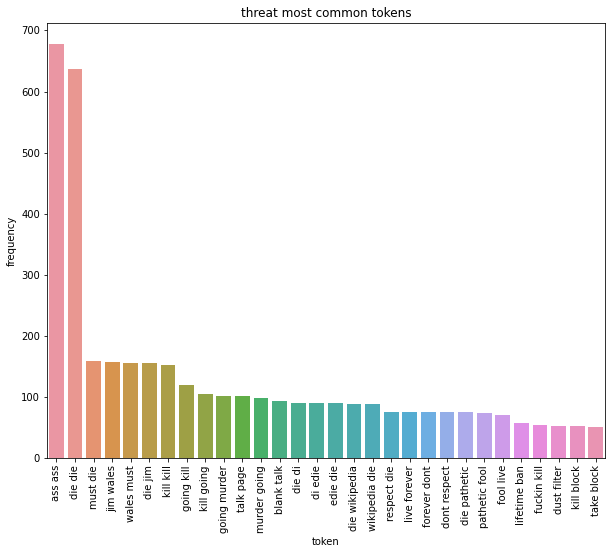

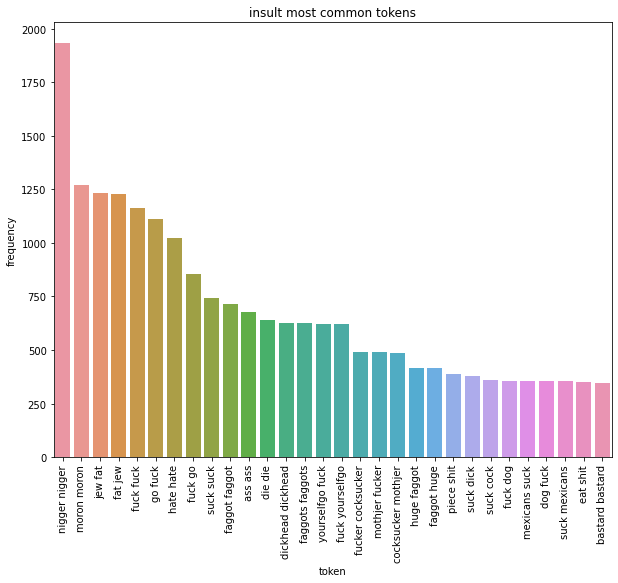

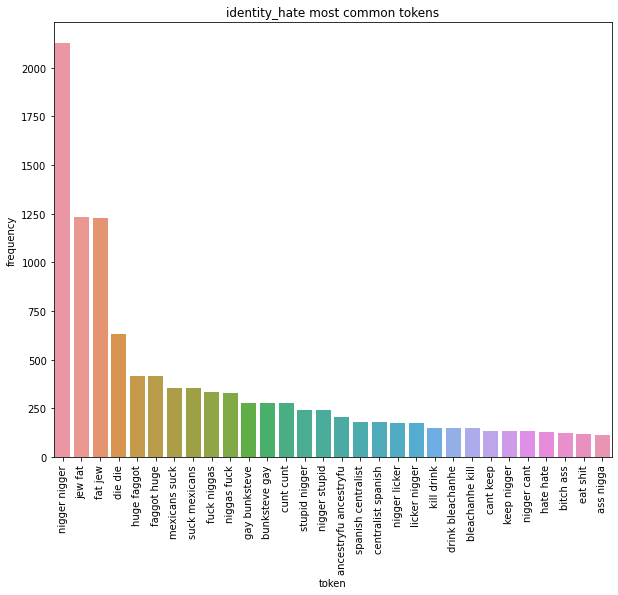

In [ ]:
for i in ['clean', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
  gram_freq(df_train, 2, i, 'min_clean_text')